## Practical Exercise: Program a Rabi experiment


Qililab supports pulse-level programming through the QProgram class. This exercise aims to introduce students to pulse-level programming using QProgram by guiding them through a Rabi experiment, which is an essential step in the calibration cycle of any quantum computer.

### What is a Rabi Experiment?

A Rabi experiment aims to find the drive pulse amplitude that will excite a qubit from 
ground state, $| 0 \rangle$, to the excited state, $| 1 \rangle$. To achieve this, we scan the pulse amplitude to observe the driving period of the qubit, which is best illustrated in the Bloch sphere.
As the amplitude increases, the qubit is driven to the 
excited state, and back to the ground state, that is, a $360\degree$ rotation around $\sigma_x$ on the Bloch sphere.


<div>
<img src="../media/bloch.gif" width="300"/>
</div>


The amplitude corresponding to one half of the driving cycle is the Rabi amplitude, which is the pulse amplitude needed to perform an excitation
from $| 0 \rangle$ to $| 1 \rangle$. 


<!-- This translates into the next basic circuit:

<div>
<img src="images/rabi_circuit.png" width="300"/>
</div>

In this circuit, we are performing first a rotation of $\pi$ radians around the $X$ axis of the Bloch sphere, starting from the
ground state, which should drive our qubit to the excited state. Then we measure the expected value, on the $Z$ axis base, this is
$\langle \sigma_z \rangle$ and register the measured value. 

Breaking this step by step, starting in the ground state $| 0 \rangle = \left[\begin{array}{ll}
1 & 0
\end{array}\right]^T$ we first perform the $\pi$ radians rotation about the $X$ axis of the Bloch sphere:

$R_x\left(\pi\right)=e^{-i \pi \sigma_x / 2}=\left[\begin{array}{cc}
\cos \cfrac{\pi}{2} & -i \sin \cfrac{\pi}{2} \\
-i \sin \cfrac{\pi}{2} & \cos \cfrac{\pi}{2}
\end{array}\right] = \left[\begin{array}{cc}
0 & -i  \\
-i & 0
\end{array}\right]$

after which the qubit is in the state $| \psi \rangle = R_x | 0 \rangle$. All we have to do now is to measure the expectation value 
of the qubit on the $Z$ axis of the Bloch sphere $\langle \psi | \sigma_z | \psi \rangle$, by using the Pauli-Z operator

$\sigma_z=\left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right]$

which gives us an expectation value of $-1$, meaning our qubit is now in the excited $| 1 \rangle = \left[\begin{array}{ll}
0 & 1
\end{array}\right]^T$. -->


<!-- Let's think of how to implement this circuit and the full experiment using Qililab. -->

### What will the QProgram look like?


The QProgram we need to perform a Rabi of experiment will consist of the following procedure:

1. **Drive pulse:** A drive pulse is sent to the drive bus of the qubit, altering the qubit's state on the Bloch sphere. The amplitude of this pulse is the variable we will loop over.

2. **Measurement Pulse and Acquisition:** A measurement pulse is sent to the measurement bus, followed by signal acquisition on the same bus (note that the readout input and output are mapped to the same bus). A waiting time must be set between the measurement pulse and acquisition to account for the time of flight—the time it takes for the pulse to travel to the quantum chip and back to the digitizer. This can be approximated by the speed of light multiplied by the length of the path the pulse travels.

3. We will loop over this sequence, varying the drive pulse amplitude using a for loop.

4. The whole sequence should be repeated within a hardware averaging loop, with sufficient waiting time between iterations. Performing the experiment multiple times and averaging the results will help obtain a cleaner signal, reducing inherent system noise.


Note: To ensure simplicity and consistency, all students should conduct their experiments on QUBIT 4.

## Let's start programming!

#### Importing Qililab, API and Other Useful Packages

In [7]:
import qililab as ql
from qililab import QProgram
from qililab.utils import from_dict
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration
import matplotlib.pyplot as plt
import numpy as np

#### Initialise API with your credentials



In [ ]:
api = API(ConnectionConfiguration(username="youruser", api_key="yourkey"))
api.select_device_id(16)

#### Define waveforms

Using pulse-level programming, we gain direct access to the shape of the pulses (the waveforms) that control our quantum chip. You will need one waveform for the drive pulse, another for the readout pulse, and integration weights for the acquisition.


In [3]:
# Let's create a readout pulse for our Rabi experiment with the calibrated measurement gate (M gate) parameters:

runcard = api.get_runcard(runcard_name="saruman")
runcard_as_dict = runcard.runcard

RO_duration= runcard_as_dict["gates_settings"]["gates"][f"M(4)"][0]["pulse"]["duration"]
RO_amplitude= runcard_as_dict["gates_settings"]["gates"][f"M(4)"][0]["pulse"]["amplitude"]

In [4]:
from qililab import IQPair, Gaussian, Square

# Waveform for drive pulse. The amplitude is set to 1, since we are going to loop over gain later. 
drive_wf = IQPair( I=Gaussian( amplitude=1.0, duration=40, num_sigmas=4.0 ), Q=Gaussian( amplitude=0.0, duration=40, num_sigmas=4.0 ) )

# Waveform for readout pulse. We can use the same parameters as the ones in the calibrated M gate, for optimized readout.
readout_wf = IQPair(I=Square(amplitude=RO_amplitude, duration=RO_duration), Q=Square(amplitude=0.0, duration=RO_duration))

# Integration Weights used during acquisition. We will use the simplest form, integrating across the duration of the readout pulse uniformly.
weights = IQPair(I=Square(amplitude=1.0, duration=RO_duration), Q=Square(amplitude=1.0, duration=RO_duration))

#### Define experiment parameters

You will need the following experimental parameters to write the qprogram:

- The number of hardware averages ( <span style="color:darkblue"> HW_AVG </span> ). Repeating the sequence and averaging is essential to obtain a clear signal. For the current system, we will need around 1_000-5_000 averages.

- The Relax duration (<span style="color:darkblue">   RELAX_DURATION  </span>  ) is the wait from one execution to the next. This wait time accounts for the extra time required for the qubit to relax back to its ground state. For the case of a transmon qubit, a wait time of 200_000 ns is sufficient.

- The time of flight (<span style="color:darkblue"> TOF </span> ) is the time it takes for the pulse to travel to the quantum chip and back to the digitizer. The TOF has been calibrated for this system, and should be set to 200 ns.

In [5]:
HW_AVG = 3_000
RELAX_DURATION = 200_000
TOF= 200

#### Create the quantum program with QProrgam

With the parameters and waveforms defined, we now have all the necessary components to build the QProgram. This task is left as an exercise for the student. You can refer to the solved exercise for guidance, but we encourage experimenting with different approaches until you dinf out what works. Good luck !


In [8]:
# Bus names
readout_bus= "readout_q4_bus"
drive_bus = "drive_q4_bus"

# Initialise QProgram
qp_rabi = QProgram()

# Declare a variable for the for loop
gain = qp_rabi.variable(ql.Domain.Voltage)

# Define the amplitude values to loop over
AMP_VALUES = np.arange(0, 0.2, 0.005)

# Loop over the the variable's value over the range
with qp_rabi.average(HW_AVG):
    with qp_rabi.for_loop(variable=gain, start= AMP_VALUES[0], stop=AMP_VALUES[-1], step=AMP_VALUES[1]-AMP_VALUES[0]):
        # Change the gain output of the drive_bus
        qp_rabi.set_gain(bus= drive_bus, gain=gain)

        # Play the control pulse
        qp_rabi.play(bus=drive_bus, waveform=drive_wf)

        # Sync the buses
        qp_rabi.sync()

        # Measure
        qp_rabi.play(bus=readout_bus, waveform=readout_wf, wait_time= TOF) #tof  ## send readout pulse
        qp_rabi.acquire(bus=readout_bus, weights=weights)

        qp_rabi.wait(readout_bus, duration= RELAX_DURATION)

#### Execute the Qprogram and retrieve the results

In [9]:
job_id = api.execute(qprogram= qp_rabi.to_dict(), name="yourname")[0]

In [ ]:
job_result = api.get_result(job_id)
results = from_dict(job_result)
results_array= results.results[readout_bus][0].array

If your execution fails, you can check the error logs with the following:

In [ ]:
api.get_job(job_id).logs

#### Plot and fit your data and find the Rabi amplitude!

In [12]:
def plot_iq(xdata, results: np.ndarray, title_label: str, xlabel: str):
    fig, axes = plt.subplots(1, 2, figsize=(13, 7))

    if isinstance(axes, np.ndarray):
        axes[0].plot(xdata, results[0], "--o", color="blue")
        axes[1].plot(xdata, results[1], "--o", color="blue")
        axes[0].set_title("I")
        axes[1].set_title("Q")
        axes[0].set_xlabel(xlabel)
        axes[1].set_xlabel(xlabel)
        axes[0].set_ylabel("Voltage [a.u.]")
        axes[1].set_ylabel("Voltage [a.u.]")
        
    fig.suptitle(title_label)
    return fig, axes

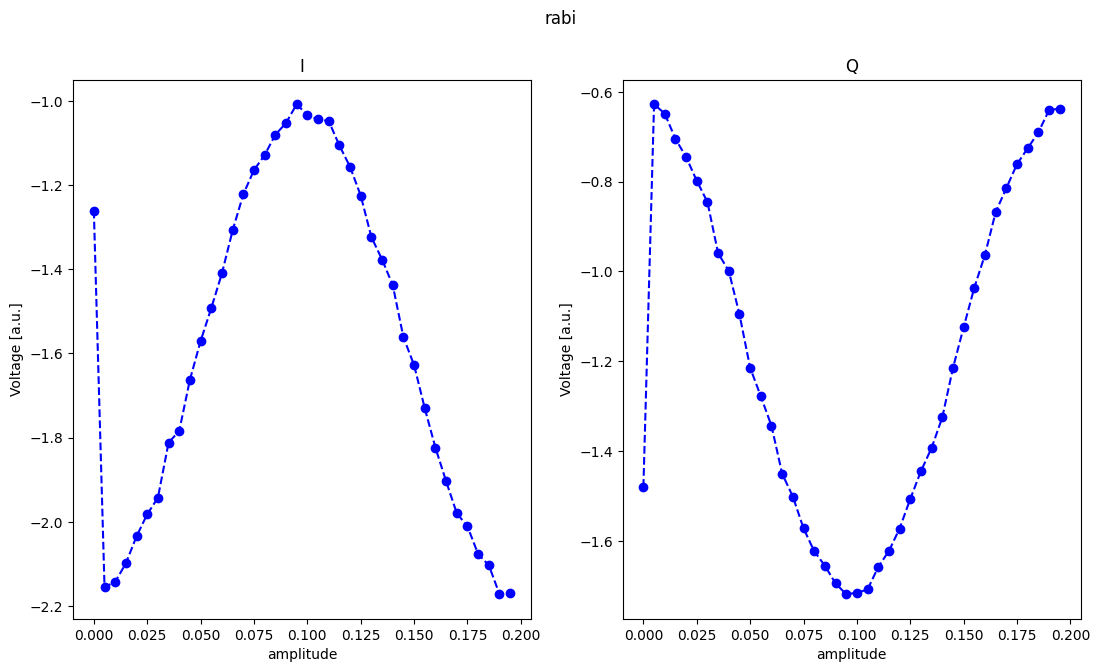

In [13]:
plot_iq(xdata=AMP_VALUES, results=results_array, title_label="rabi", xlabel="amplitude")
plt.show()

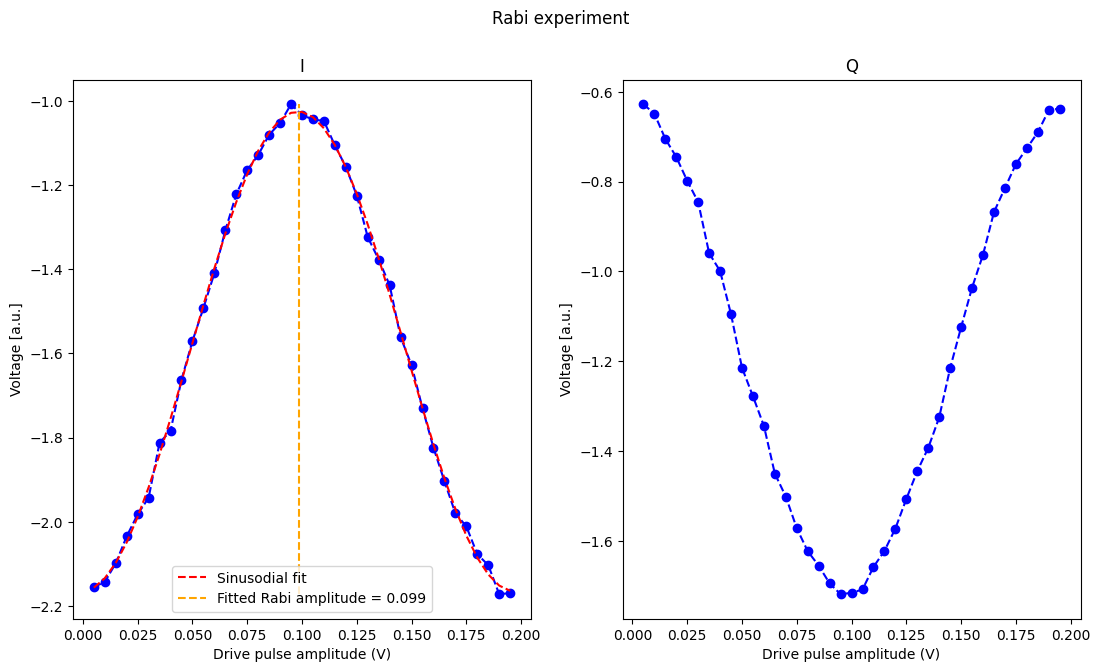

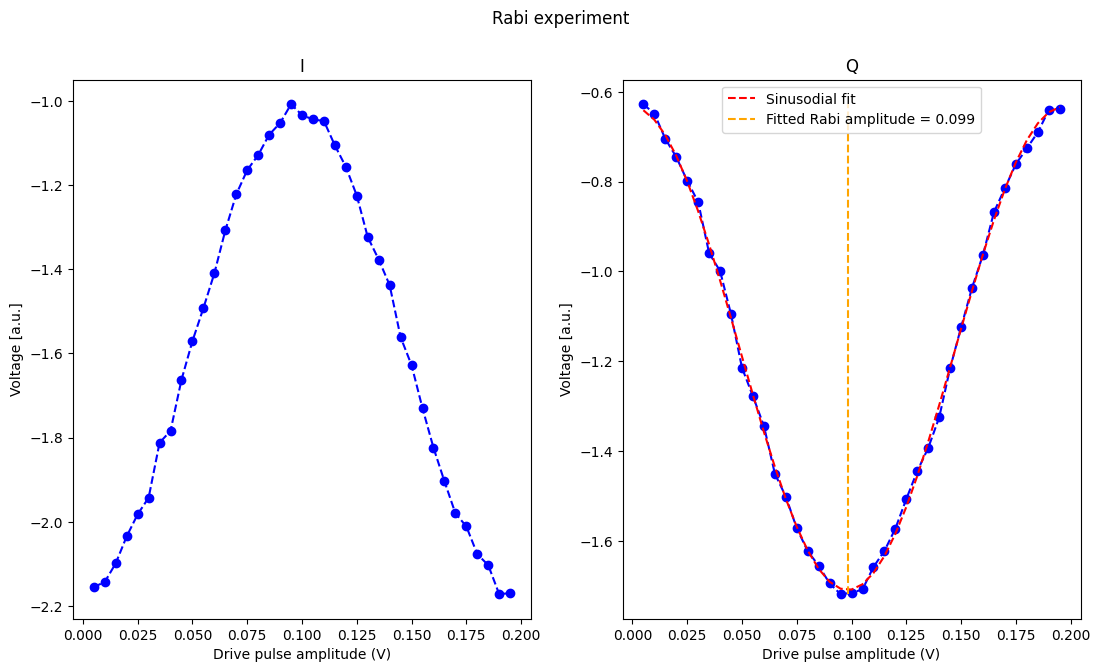

In [14]:
# Fitting the signal with a sinusoidal fit
import lmfit

# exclude bad points
x_array= AMP_VALUES[1:]
iq_array= results_array[:,1:]

def sinus(x, a, b, c, d):
    return a * np.sin(b * np.array(x) - c) + d

for fit_quadrature in ["i", "q"]:
    data_array = iq_array[0] if fit_quadrature == "i" else iq_array[1]

    #Sinus fit
    mod = lmfit.Model(sinus)

    ff = np.fft.fftfreq(len(x_array), (x_array[1] - x_array[0])) * 2 * np.pi  # assume uniform spacing
    Fyy = abs(np.fft.fft(data_array))
    Fyy
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(data_array) * 2.0**0.5
    guess_offset = np.mean(data_array)

    # Set initial guesses
    mod.set_param_hint("a", value= guess_amp )
    mod.set_param_hint("b", value=guess_freq)
    mod.set_param_hint("c", value=0)
    mod.set_param_hint("d", value=guess_offset)
    guess_freq
    params = mod.make_params()
    fit = mod.fit(data=data_array, params=params, x=x_array, method="basinhopping")

    a_value = fit.params["a"].value
    b_value = fit.params["b"].value
    c_value = fit.params["c"].value
    d_value = fit.params["d"].value
    popt = [a_value, b_value, c_value, d_value]

    # Rabi amplitude is the half period amplitude
    rabi_amp = np.pi/b_value
    # Find closes amplitude in array
    rabi_amp_idx = np.abs(x_array - rabi_amp).argmin()

    fit_plot = sinus(x_array, *popt)
    fig, axes = plot_iq(xdata=x_array, results=iq_array, title_label=f"Rabi experiment", xlabel="Drive pulse amplitude (V)")
    ax = axes[0 if fit_quadrature == "i" else 1]
    ax.plot(x_array, fit_plot, "--", color="red", label="Sinusodial fit" )
    ax.vlines(rabi_amp, ymin=min(data_array), ymax=max(data_array), linestyles ="dashed", color="orange",label=f"Fitted Rabi amplitude = {rabi_amp:.3f}" )
    ax.legend()


### Finally share and compare your results with peers. Congratulations, you just performed a Qubit calibration experiment! 